# AI - CA5 - CNN task
* tumor detection
* Mohammad Mahdi Salmani

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import gdown
import os
import zipfile
import random
from torchsummary import summary

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
url = "https://drive.google.com/file/d/1dp1AzTaXIQeGE58CqeO4UclplA28Q5C9/view?usp=sharing"
zip_file_path = "AI-CA5-Dataset.zip"

gdown.download(url, zip_file_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1dp1AzTaXIQeGE58CqeO4UclplA28Q5C9
To: /content/AI-CA5-Dataset.zip
100%|██████████| 25.6M/25.6M [00:00<00:00, 121MB/s]


'AI-CA5-Dataset.zip'

In [4]:
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()
    os.remove(zip_file_path)

## Preprocess dataset

* Customize Dataset class

In [5]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_path, transform=None):
        self.root_path = root_path
        self.transform = transform
        self.classes = ['notumor', 'glioma', 'meningioma', 'pituitary']
        self.images, self.labels = self.load_data()

    def load_data(self):
        images = []
        labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_path = f'{self.root_path}/{class_name}/'
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append(img_path)
                labels.append(class_idx)

        return images, labels

    def show_image(self, class_name, size=(512, 512)):
        image_path = f"{self.root_path}/{class_name}"
        image_name = random.choice(os.listdir(image_path))
        image = Image.open(f'{image_path}/{image_name}').convert("RGB")
        image = image.resize(size)
        print(image_name)
        display(image)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, label

* Resize and Normalize dataset

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_path = '/content/AI-CA5-Dataset'
dataset = BrainTumorDataset(data_path, transform=transform)

In [8]:
sample, label = dataset[0]
print(f"Sample shape: {sample.shape}, Label: {label}")
print(f"Dataset size: {len(dataset)}")

Sample shape: torch.Size([3, 512, 512]), Label: 0
Dataset size: 1311


In [118]:
print('max:',torch.max(dataset[1][0]))
print('min:',torch.min(dataset[1][0]))

max: tensor(1.)
min: tensor(-1.)


* Split dataset to test and train sets

In [9]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(
    dataset,
    test_size=0.2,
    stratify=dataset.labels,
    random_state=42,
    shuffle=True,
)

* plot class distribution for train and test sets

In [ ]:
def plot_class_distribution(labels, classes, title):
    classes, counts = zip(*[(class_name, labels.count(class_idx)) for class_idx, class_name in enumerate(classes)])
    plt.bar(classes, counts,width=0.5)
    plt.title(title)
    plt.show()

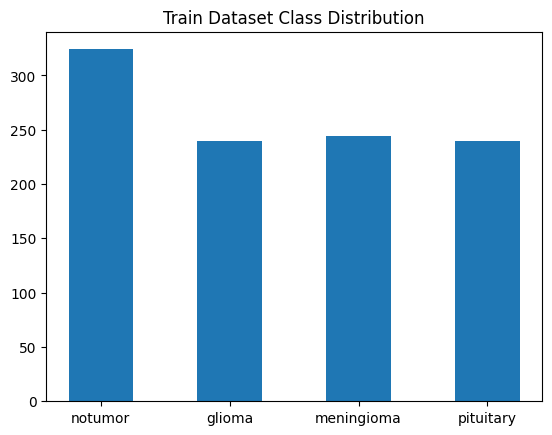

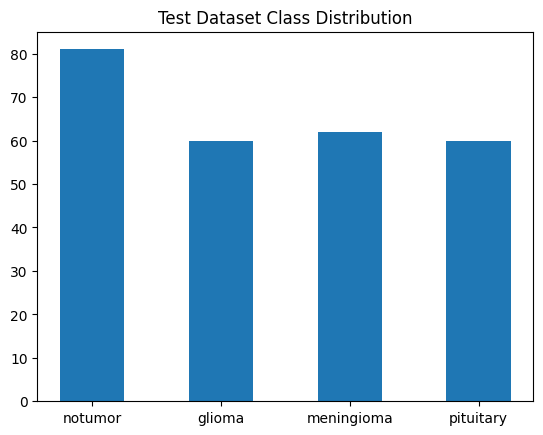

In [ ]:
plot_class_distribution([label for _,label in train_dataset], dataset.classes, 'Train Dataset Class Distribution')
plot_class_distribution([label for _,label in test_dataset], dataset.classes, 'Test Dataset Class Distribution')

* Display one image foe each class


Class name: notumor
Image name: Te-no_0311.jpg


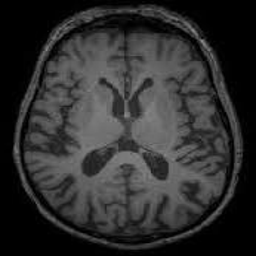


Class name: glioma
Image name: Te-gl_0140.jpg


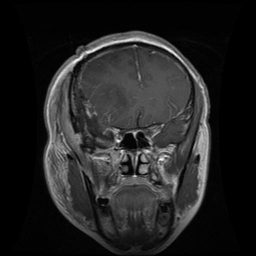


Class name: meningioma
Image name: Te-me_0263.jpg


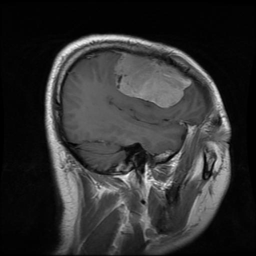


Class name: pituitary
Image name: Te-pi_0170.jpg


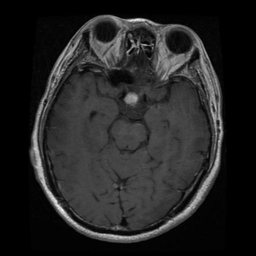

In [ ]:
for class_name in dataset.classes:
    print(f'\nClass name: {class_name}\nImage name:',end=' ')
    dataset.show_image(class_name,size=(256,256))

* Model

In [52]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomModel, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(32, 64, kernel_size=5, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
        )
        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.calculate_fc_input_size(), 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(),

            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(),

            nn.Linear(1024, num_classes),
            # nn.Softmax()
        )

    def calculate_fc_input_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 512, 512)
            feature_output = self.feature(dummy_input)
        size = feature_output.view(dummy_input.size(0), -1).size(1)
        return size

    def forward(self, x):
        x = self.feature(x)
        x = self.classification(x)
        return x

In [54]:
import gc
# del model
gc.collect()
torch.cuda.empty_cache()

In [55]:
model = CustomModel().to(device)
print(summary(model, (3,512,512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 508, 508]           1,216
       BatchNorm2d-2         [-1, 16, 508, 508]              32
              ReLU-3         [-1, 16, 508, 508]               0
         AvgPool2d-4         [-1, 16, 254, 254]               0
         Dropout2d-5         [-1, 16, 254, 254]               0
            Conv2d-6         [-1, 32, 250, 250]          12,832
       BatchNorm2d-7         [-1, 32, 250, 250]              64
              ReLU-8         [-1, 32, 250, 250]               0
         AvgPool2d-9         [-1, 32, 125, 125]               0
        Dropout2d-10         [-1, 32, 125, 125]               0
           Conv2d-11         [-1, 64, 121, 121]          51,264
      BatchNorm2d-12         [-1, 64, 121, 121]             128
             ReLU-13         [-1, 64, 121, 121]               0
        AvgPool2d-14           [-1, 64,

* Data loader

In [56]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

* Define optimizer and Loss function

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

* Train the model

In [58]:
num_epochs = 25

model.to(device)

losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    losses.append(epoch_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} => Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/25 => Loss: 1.2060, Accuracy: 0.5324
Epoch 2/25 => Loss: 0.7786, Accuracy: 0.6842
Epoch 3/25 => Loss: 0.7221, Accuracy: 0.7300
Epoch 4/25 => Loss: 0.5761, Accuracy: 0.7662
Epoch 5/25 => Loss: 0.4888, Accuracy: 0.8073
Epoch 6/25 => Loss: 0.4219, Accuracy: 0.8206
Epoch 7/25 => Loss: 0.4331, Accuracy: 0.8445
Epoch 8/25 => Loss: 0.3224, Accuracy: 0.8798
Epoch 9/25 => Loss: 0.3038, Accuracy: 0.8893
Epoch 10/25 => Loss: 0.3228, Accuracy: 0.8865
Epoch 11/25 => Loss: 0.3095, Accuracy: 0.8874
Epoch 12/25 => Loss: 0.2206, Accuracy: 0.9198
Epoch 13/25 => Loss: 0.1741, Accuracy: 0.9447
Epoch 14/25 => Loss: 0.1949, Accuracy: 0.9265
Epoch 15/25 => Loss: 0.1665, Accuracy: 0.9427
Epoch 16/25 => Loss: 0.1617, Accuracy: 0.9380
Epoch 17/25 => Loss: 0.1504, Accuracy: 0.9456
Epoch 18/25 => Loss: 0.1375, Accuracy: 0.9504
Epoch 19/25 => Loss: 0.1208, Accuracy: 0.9552
Epoch 20/25 => Loss: 0.1011, Accuracy: 0.9609
Epoch 21/25 => Loss: 0.1460, Accuracy: 0.9437
Epoch 22/25 => Loss: 0.1513, Accuracy: 0.94

* Plotting the loss and accuracy

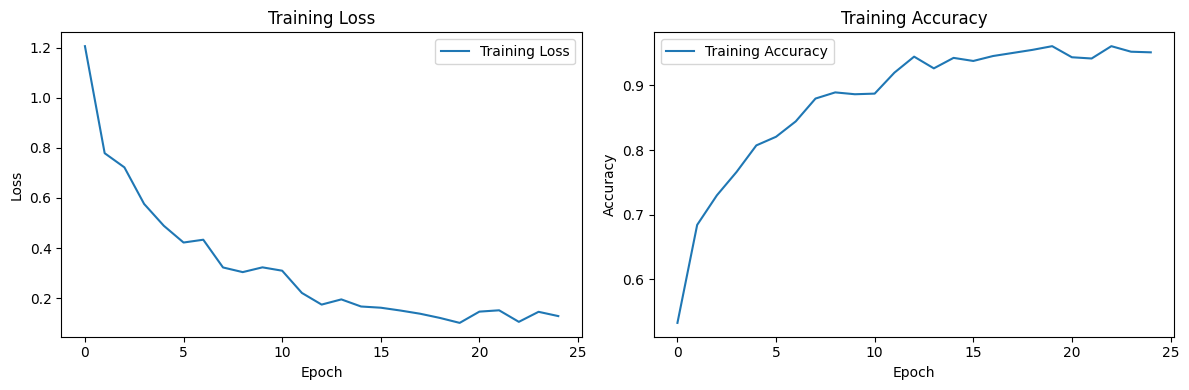

In [61]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

* evaluate the model on the test set

In [59]:
def evaluate_metrics(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [60]:
evaluate_metrics(model, test_loader)

Accuracy: 0.8251
Precision: 0.8231
Recall: 0.8251
F1 Score: 0.8236


* Save the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), 'cnn_model_2.pth')

In [ ]:
import shutil
shutil.copyfile('/content/cnn_model_2.pth', '/content/drive/MyDrive/cnn_model_2.pth')

'/content/drive/MyDrive/cnn_model_2.pth'